# A modification tutorial of [Using a custom botorch model with Ax](https://botorch.org/v/0.6.0/tutorials/custom_botorch_model_in_ax)

### Import necessary modules

In [1]:
from botorch.models.gpytorch import GPyTorchModel
from gpytorch.distributions import MultivariateNormal
from gpytorch.means import ConstantMean
from gpytorch.models import ExactGP
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.likelihoods.gaussian_likelihood import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model
from ax.core import SimpleExperiment
from ax.modelbridge import get_sobol
from ax import ParameterType, SearchSpace, RangeParameter
import numpy as np
from ax.modelbridge.factory import get_botorch
import random

training_samples = 20
opt_iterations = 20
random_seed = 100

### Define a GP surrogate model

In [2]:
class SimpleCustomGP(ExactGP, GPyTorchModel):
    _num_outputs = 1  # to inform GPyTorchModel API

    def __init__(self, train_X, train_Y):
        # squeeze output dim before passing train_Y to ExactGP
        super().__init__(train_X, train_Y.squeeze(-1), GaussianLikelihood())
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(
            base_kernel=RBFKernel(ard_num_dims=train_X.shape[-1]),
        )
        self.to(train_X)  # make sure we're on the right device/dtype

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

### Define a function to build GP and fit GP, return the fitted GP

In [3]:
def get_and_fit_simple_custom_gp(Xs, Ys, **kwargs):
    model = SimpleCustomGP(Xs[0], Ys[0])
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    return model

### Define the optimization problem
You can change this function to your optimization problem, only keep the arguments *(X)* and return *{name: (y, 0.0)}* unchanged.

In [4]:
name = "branin"
def branin(X):
    x1, x2 = X["x1"], X["x2"]
    y = (x2 - 5.1 / (4 * np.pi ** 2) * x1 ** 2 + 5 / np.pi * x1 - 6) ** 2
    y += 10 * (1 - 1 / (8 * np.pi)) * np.cos(x1) + 10
    # let's add some synthetic observation noise
    y += random.normalvariate(0, 0.1)
    return {name: (y, 0.0)}

### Build an experiment and return

In [5]:
def build_exp(search_space, seed=random_seed, minimize=True):
    exp = SimpleExperiment(
        name=name,
        search_space=search_space,
        evaluation_function=branin, # should be the same function name you defined in last step
        objective_name=name,
        minimize=minimize,
    )
    sobol = get_sobol(exp.search_space, seed=seed)
    exp.new_batch_trial(generator_run=sobol.gen(training_samples))
    return exp

### Define the optimization loop

This loop is different from the Botorch tutorial. In that tutorial, the optimization stops after generating a sample, i.e. training -> generating -> training -> ... -> training -> generating.

With this loop, the optimization stops after training a final model. The number of all samples is the same with what we defined.

In [6]:
def optimize(search_space, seed, minimize=True):
    exp = build_exp(search_space, seed, minimize)
    # buiding the initial GP
    model = get_botorch(
        experiment=exp,
        data=exp.eval(),
        search_space=exp.search_space,
        model_constructor=get_and_fit_simple_custom_gp,
    )
    # start optimization loop
    for i in range(opt_iterations):
        generator_run = model.gen(1)
        exp.new_trial(generator_run=generator_run)
        model = get_botorch(
            experiment=exp,
            data=exp.eval(),
            search_space=exp.search_space,
            model_constructor=get_and_fit_simple_custom_gp,
        )
        print(f"Running optimization batch {i + 1}/{opt_iterations}...")
    print("Done!")
    return model

### Optimizing the Branin funciton

In [7]:
parameter_space = SearchSpace(
    parameters=[
        RangeParameter(
            name="x1",
            parameter_type=ParameterType.FLOAT,
            lower=-5,
            upper=10
        ),
        RangeParameter(
            name="x2",
            parameter_type=ParameterType.FLOAT,
            lower=0,
            upper=15
        ),
    ]
)
model = optimize(
    search_space=parameter_space,
    seed=random_seed
)

Running optimization batch 1/20...
Running optimization batch 2/20...
Running optimization batch 3/20...
Running optimization batch 4/20...
Running optimization batch 5/20...
Running optimization batch 6/20...
Running optimization batch 7/20...
Running optimization batch 8/20...
Running optimization batch 9/20...
Running optimization batch 10/20...
Running optimization batch 11/20...
Running optimization batch 12/20...
Running optimization batch 13/20...
Running optimization batch 14/20...
Running optimization batch 15/20...
Running optimization batch 16/20...
Running optimization batch 17/20...
Running optimization batch 18/20...
Running optimization batch 19/20...
Running optimization batch 20/20...
Done!


### Plot the GP model and samples

/home/yiqi/Software/envs/gpytorch/lib/python3.8/site-packages/torch/functional.py:445: UserWarning:

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)



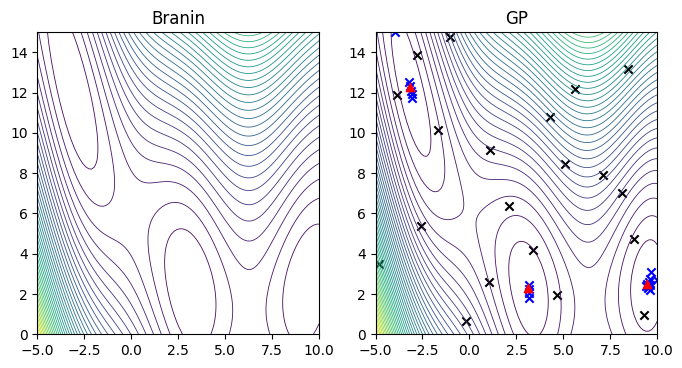

In [8]:
import matplotlib.pyplot as plt
from ax.models.torch.utils import predict_from_model
import torch
import gpytorch

# GP takes normalized input between (0, 1)
n = 100
x1= torch.linspace(0, 1, n).reshape((-1, 1))
x2 = torch.linspace(0, 1, n).reshape((-1, 1))
x1_x2= torch.cat((x1, x2), 1)
x1_x2 = gpytorch.utils.grid.create_data_from_grid(x1_x2)

pred, var = predict_from_model(model.model.model, x1_x2)
pred = pred.numpy().reshape(n, n)

# We plot GP using real range
x1= torch.linspace(-5, 10, n).reshape((-1, 1))
x2 = torch.linspace(0, 15, n).reshape((-1, 1))
x1, x2 = np.meshgrid(x1, x2)

plt.figure(figsize=(8, 4), dpi=100)
# plot true branin
plt.subplot(1, 2, 1)
plt.contour(x1, x2, branin({"x1": x1, "x2": x2})[name][0], linewidths=0.6, levels=50)
plt.title("Branin")
# plot GP
# black crosses are initial samples, blues are opt samples and red triangles are real minimums
plt.subplot(1, 2, 2)
plt.contour(x1, x2, pred, linewidths=0.6, levels=50)
for i, obs in enumerate(model.get_training_data()):
    color = "black" if i < opt_iterations else "blue"
    plt.scatter(obs.features.parameters["x1"], obs.features.parameters["x2"], c=color, marker="x")
# plot the analytical solutions
plt.scatter([-np.pi, np.pi, 9.42478], [12.275, 2.275, 2.475], c="red", marker="^")
plt.title("GP")
plt.show()